## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll define helper methods

In [28]:
def print_image_grid(images, columns=3):
    """
    A helper method for drawing multiple images in a grid
    """
    f = plt.figure(figsize=(20, 100)) # width, height in inches. If not provided, defaults to rc figure.figsize.
    for i, img in enumerate(images):
        splt = plt.subplot(len(images) / columns + 1, columns, i + 1)
        splt.set_title(img[0], fontsize=20)
        if len(img[1].shape) > 2:
            splt.imshow(img[1])
        else:
            splt.imshow(img[1], cmap='gray')

## Then I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt4
%matplotlib inline

chessboard_nx = 9
chassboard_ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chassboard_ny*chessboard_nx,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_nx,0:chassboard_ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

img_shape = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape[::-1]

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chassboard_ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (chessboard_nx,chassboard_ny), corners, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, cc_mtx, cc_dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
if not ret:
    raise Exception("Cannot calibrate camera")
print("Calibration succeeded")

Calibration succeeded


## And define the method for undistoring images

In [6]:
def undistort(img):
    """
    Distortion correction using the parameters gotten after camera calibration
    returns an undistorted image
    """
    return cv2.undistort(img, cc_mtx, cc_dist, None, cc_mtx)

## Then I'll choose parameters for perspective transformation

Lane width: 550px
Resolution: 0.00673 m/px


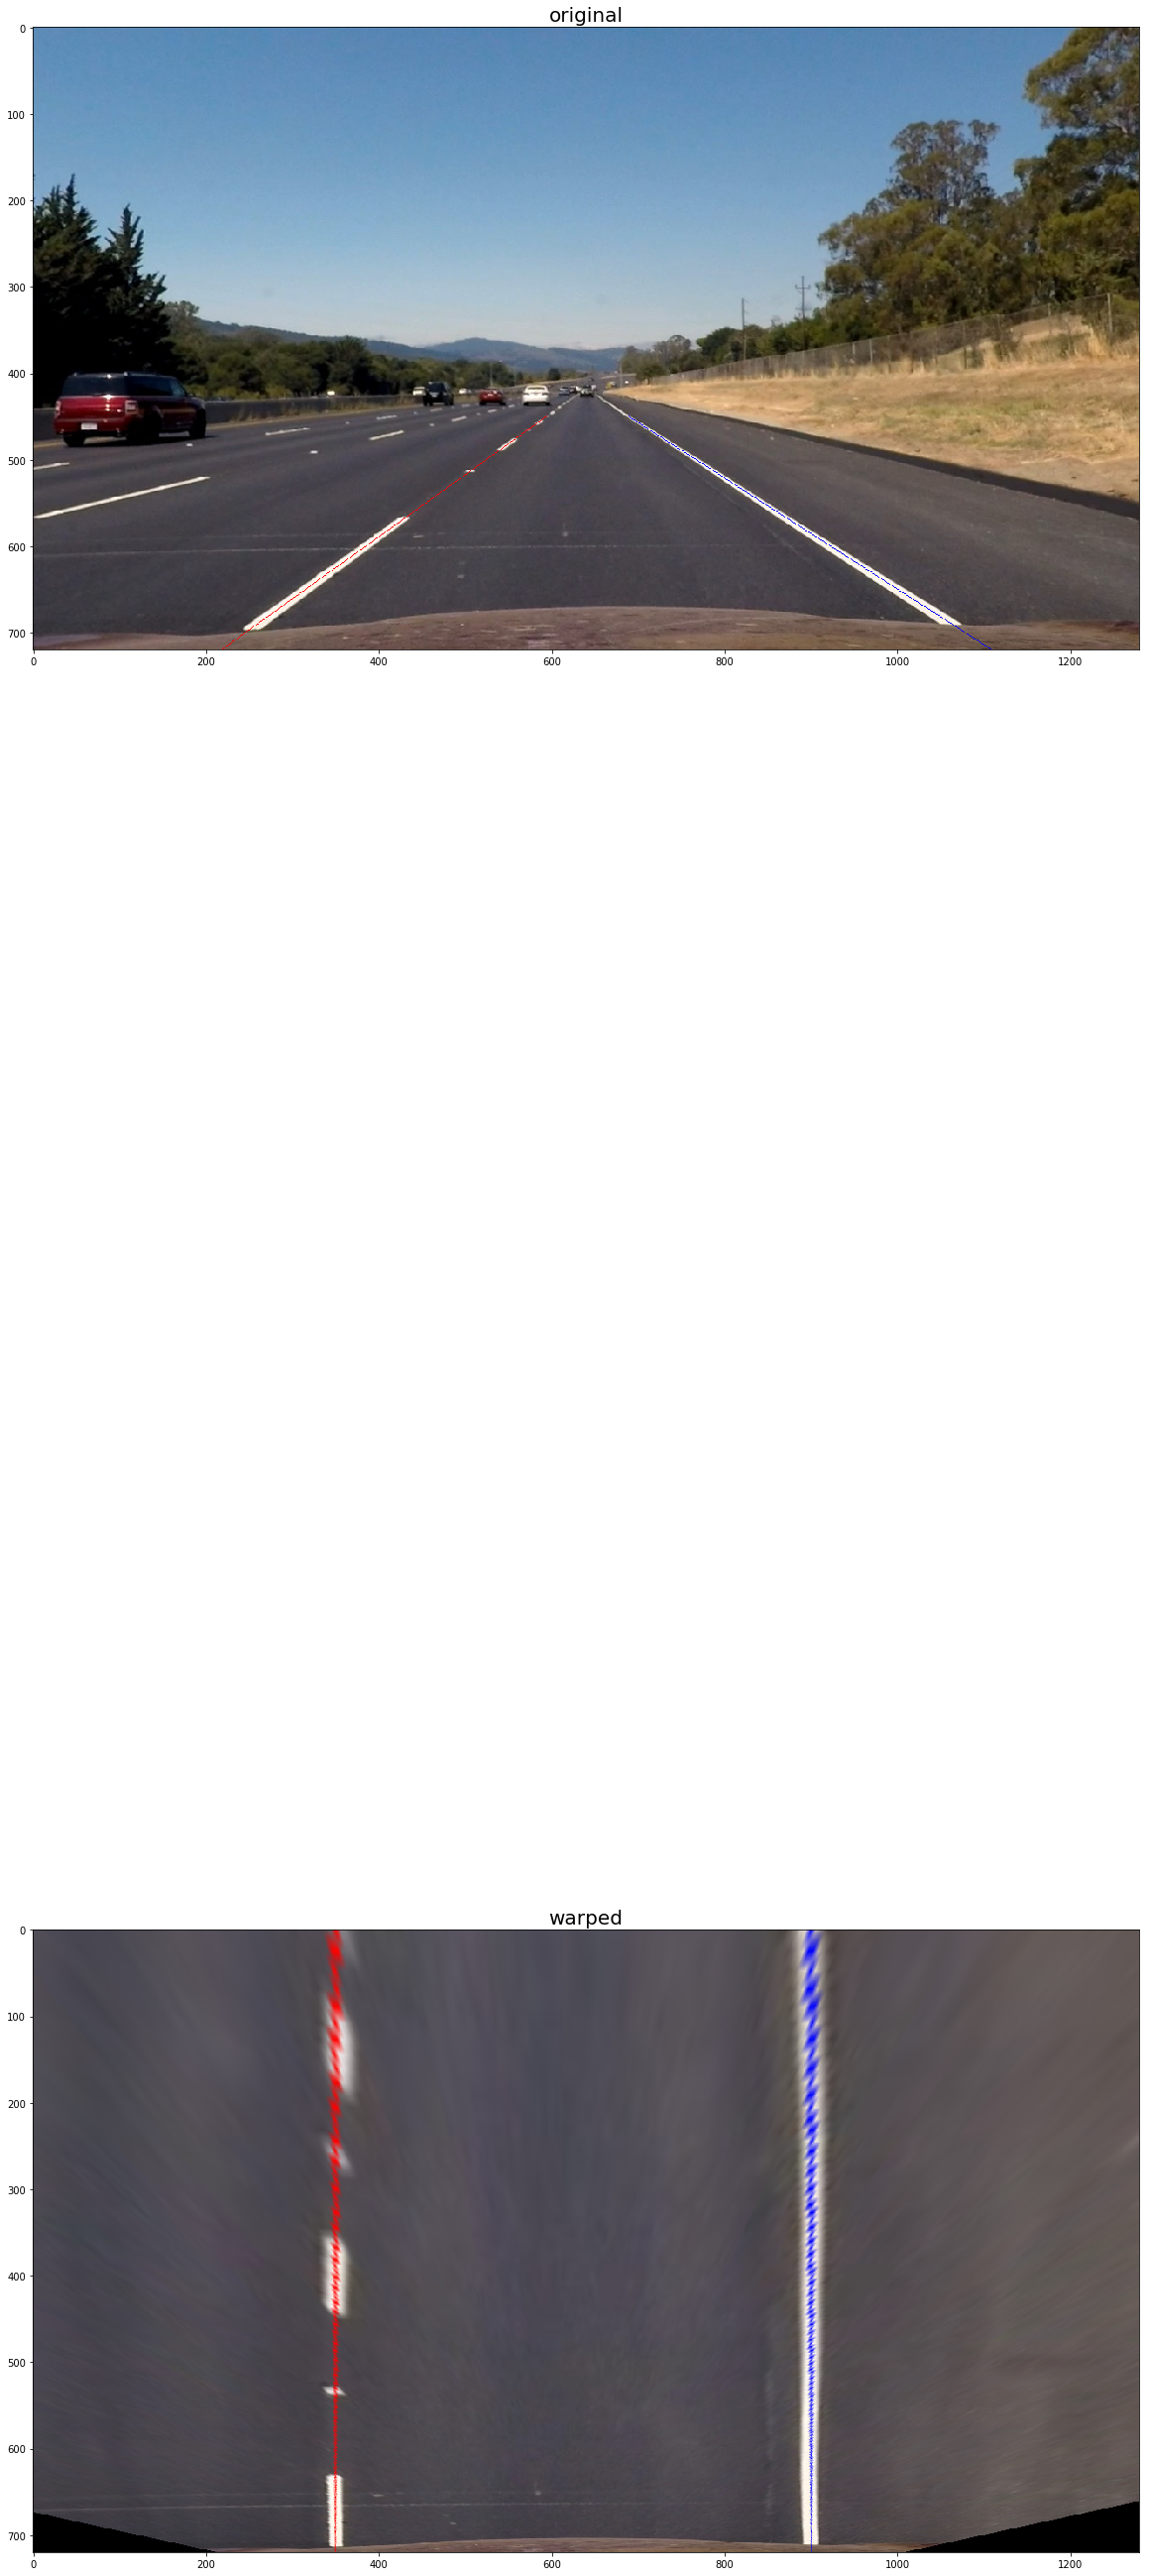

In [418]:
# Choosing parameters for perpective transformation
fname = './test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

img_undistorted = undistort(img)
img_height = img_undistorted.shape[0]

top_y = 450

#lx1 = 200
#ly1 = img_height
#lx2 = 592
#ly2 = top_y
#cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=1)

#rx1 = 1126
#ry1 = img_height
#rx2 = 692
#ry2 = top_y
#cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=1)

lx1 = 218
ly1 = img_height
lx2 = 594
ly2 = top_y
cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=1)

rx1 = 1109
ry1 = img_height
rx2 = 689
ry2 = top_y
cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=1)

src = np.float32([
    [lx1, ly1], # bottom left
    [lx2, ly2], # top left
    [rx2, ry2], # top right
    [rx1, ry1]  # bottom right
]) 

lwx = 350 # left warped x-coordinate
rwx = 900 # right warped x-coordinate
dst = np.float32([
    [lwx, img_height], # bottom left
    [lwx, 0],          # top left
    [rwx, 0],          # top right
    [rwx, img_height]  # bottom right
])

img_height = img.shape[0]
img_width = img.shape[1]

warped_lane_width_px = rwx - lwx # lane width in pixels
warped_xm_per_px = 3.7 / warped_lane_width_px # the number of meters in a pixel
warped_ym_per_px = 30. / img_height # the number of meters in a pixel  

print('Lane width: %dpx' % warped_lane_width_px)
print('Resolution: %0.5f m/px' % warped_xm_per_px)



M = cv2.getPerspectiveTransform(src, dst)
Minv = np.linalg.inv(M)

img_size = (img_undistorted.shape[1], img_undistorted.shape[0])
img_warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)

print_image_grid([('original', img_undistorted), ('warped', img_warped)], 1)

## And define a method for the transformation

In [51]:
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

## Let's find a region of interest

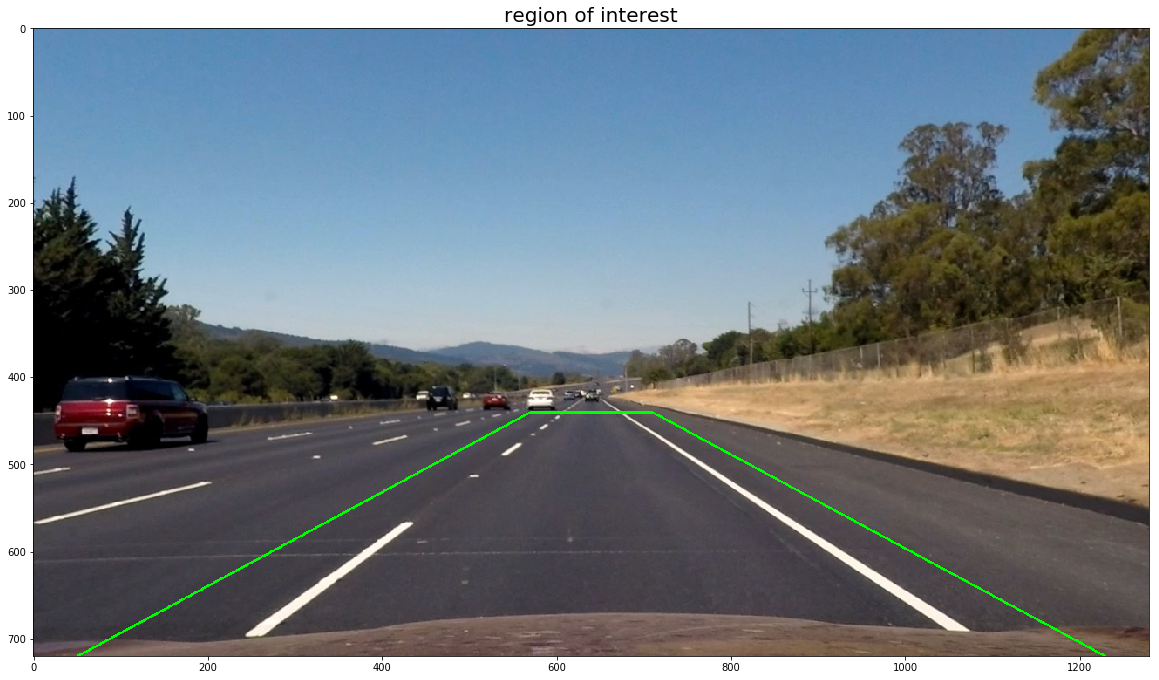

In [52]:
fname = './test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

img_undist = undistort(img)
img_height = img_undist.shape[0]
img_width = img_undist.shape[1]

color = [0,255,0]
thickness = 2

ror_height = 440

x1 = 50
y1 = img_height
x2 = 570
y2 = ror_height
x3 = 710
y3 = ror_height
x4 = img_width - 50
y4 = img_height

cv2.line(img_undist, (x1, y1), (x2, y2), color=color, thickness=thickness)
cv2.line(img_undist, (x2, y2), (x3, y3), color=color, thickness=thickness)
cv2.line(img_undist, (x3, y3), (x4, y4), color=color, thickness=thickness)

print_image_grid([('region of interest', img_undist)], 1)

ror_vertices = np.array([[(x1,y1),(x2,y2),(x3,y3),(x4,y4)]], dtype=np.int32)

## And define a method for filtering the region of interest (ROR)

In [11]:
def region_of_interest(img, vertices=ror_vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Next step is defining a pipeline for processing a single image frame

In [206]:
def grayscale(img):
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def scale_sobel(abs_sobel):
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel
    
def gray_to_sobel(gray, orient='x', ksize=3):
    if orient == 'x':
        ox = 1
        oy = 0
    else:
        ox = 0
        oy = 1
    return cv2.Sobel(gray, cv2.CV_64F, ox, oy, ksize=ksize)
    
def gray_to_scaled_sobel(gray, orient='x', ksize=3):
    sobel = gray_to_sobel(gray, orient, ksize)
    abs_sobel = np.absolute(sobel)
    return scale_sobel(abs_sobel)
    
def gray_to_scaled_mag(gray, ksize=3):
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scale_sobel(sobel)
    
def bin_mask(img, thresh=[0, 255]):
    bin_img = np.zeros_like(img)
    bin_img[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return bin_img
    
def grad_direction(gray, ksize=3):
    """
    An orientation of 0 implies a vertical line and orientations of +/−π/2 imply horizontal lines
    """
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    return grad_dir

def curvature_radius(y, fit):
    return (1 + (2*fit[0]*y + fit[1])**2)**(3/2) / np.absolute(2*fit[0])  

def polinomial(y, fit):
    return fit[0]*y**2 + fit[1]*y + fit[2] 

In [419]:
class Line():
    def __init__(self, allx, ally):
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally        
        #polynomial coefficients for fit
        self.fit = np.polyfit(ally, allx, 2)

# Define a class to receive the characteristics of each line detection
class LineDetector():
    def __init__(self, history_depth):
        # the number of last measurements which will be stored
        self.history_depth = history_depth
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None   
        # polynomial coefficients of the last n iterations
        self.recent_fits = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        # distance in meters of vehicle center from the line
        self.line_base_pos = 0
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
    def update(self, line):
        self.current_line = line
        self.detected = line is not None
        if self.detected:
            self.recent_fits.append(line.fit)
            if len(self.recent_fits) > self.history_depth:
                self.recent_fits = self.recent_fits[1:]
            self.best_fit = np.mean(self.recent_fits, axis=0)
            
            # calculating radius of curvature
            lane_length_m = warped_ym_per_px * img_height
            self.radius_of_curvature = int(curvature_radius(lane_length_m, self.best_fit))
            
            # calculating line base position
            fit = self.best_fit
            y_pos = img_height
            line_pos_px = fit[0]*y_pos**2 + fit[1]*y_pos + fit[2]
            line_base_pos_px = line_pos_px - (img_width / 2)
            self.line_base_pos = line_base_pos_px * warped_xm_per_px
            

False
(True, 3.7962276116980362)
Parallel:  True


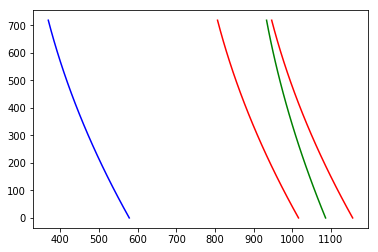

In [450]:
def sanity_check_topology(left_fit, right_fit):
    ploty = np.linspace(0, img_height - 1, 20)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    margin = 70
    
    left_border_fit = np.copy(left_fit)
    left_border_fit[2] += right_fit[2] - left_fit[2] - margin
    left_border_fitx = left_border_fit[0]*ploty**2 + left_border_fit[1]*ploty + left_border_fit[2]    

    right_border_fit = np.copy(left_fit)
    right_border_fit[2] += right_fit[2] - left_fit[2] + margin
    right_border_fitx = right_border_fit[0]*ploty**2 + right_border_fit[1]*ploty + right_border_fit[2]  

    passed = len(right_fitx[(right_fitx < left_border_fitx) | (right_fitx > right_border_fitx)]) == 0
    
    if not passed:
        print('Topology check failed, lfit=', left_fit, 'rfit=', right_fit)    
    
    return passed

def sanity_check_distance(left_fit, right_fit):
    left_pos = polinomial(img_height, left_fit)
    right_pos = polinomial(img_height, right_fit)
    distance_px = right_pos - left_pos
    diff_px = np.absolute(warped_lane_width_px - distance_px)
    diff_m = diff_px * warped_xm_per_px # diff in meters
    passed = diff_m < 0.5 # allows 50cm diff
    if not passed:
        print('Distance check failed, diff_m=', diff_m)
    return passed, distance_px * warped_xm_per_px

def sanity_check(left_line, right_line):
    # Checking that they are separated by approximately the right distance horizontally
    if not sanity_check_distance(left_line.fit, right_line.fit):
        return False
    
    # Checking that they have similar curvature and roughly parallel
    if not sanity_check_topology(left_line.fit, right_line.fit):
        return False
    
    return True


#left:  [ 3.84049533e-04 -4.82746648e-01  4.86829461e+02]
#right:  [ 5.22020818e-04 -5.70486039e-01  1.06623716e+03]

# lfit= [ 1.47552333e-04 -3.97221922e-01  5.78588246e+02] 
# rfit= [ 1.10372882e-04 -2.91573925e-01  1.08609962e+03]

left_fit = np.array([1.47552333e-04, -3.97221922e-01, 5.78588246e+02])
right_fit = np.array([1.10372882e-04, -2.91573925e-01, 1.08609962e+03])

print(sanity_check_curvature(left_fit, right_fit))
print(sanity_check_distance(left_fit, right_fit))

ploty = np.linspace(0, 720-1, 20)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
margin = 70
left_border_fit = np.copy(left_fit)
left_border_fit[2] += right_fit[2] - left_fit[2] - margin
left_border_fitx = left_border_fit[0]*ploty**2 + left_border_fit[1]*ploty + left_border_fit[2]    
    
right_border_fit = np.copy(left_fit)
right_border_fit[2] += right_fit[2] - left_fit[2] + margin
right_border_fitx = right_border_fit[0]*ploty**2 + right_border_fit[1]*ploty + right_border_fit[2]  
    
parallel = len(right_fitx[(right_fitx < left_border_fitx) | (right_fitx > right_border_fitx)]) == 0
print('Parallel: ', parallel)
    
plt.plot(left_fitx, ploty, 'b', right_fitx, ploty, 'g', 
         left_border_fitx, ploty, 'r', right_border_fitx, ploty, 'r')

In [421]:
def thresh(img):
    """
    returns a thresholded image and a list of steps
    """
    steps = []
    
    gray = grayscale(img)
    steps.append(('gray', gray))
    
    # RGB
    img_r = img[:,:,0]
    steps.append(('RGB_R', img_r))
    img_g = img[:,:,1]
    steps.append(('RGB_G', img_g))    
    img_b = img[:,:,2]    
    steps.append(('RGB_B', img_b))    
    
    # HLS
    hls = to_hls(img)
    hls_h = hls[:,:,0]
    steps.append(('HLS_H', hls_h))
    hls_l = hls[:,:,1]
    steps.append(('HLS_L', hls_l))
    hls_s = hls[:,:,2]
    steps.append(('HLS_S', hls_s))    
    
    # sobel x, y, magnitude
    sobelx = gray_to_scaled_sobel(gray, 'x')
    steps.append(('Gray-Sobel X', sobelx))
    sobely = gray_to_scaled_sobel(gray, 'y')
    steps.append(('Gray-Sobel Y', sobely))
    mag = gray_to_scaled_mag(gray)
    steps.append(('Gray-Sobel MAG', mag))
    
    hls_l_sobelx = gray_to_scaled_sobel(hls_l, 'x')
    hls_l_sobelx_thresh = bin_mask(hls_l_sobelx, thresh=[20, 100])
    steps.append(('HLS_L SobelX thresh', hls_l_sobelx_thresh))
    
    hls_s_thresh = bin_mask(hls_s, thresh=[170, 255])
    steps.append(('HLS_S thresh', hls_s_thresh))
    
    result_thresh = np.zeros_like(hls_l_sobelx_thresh)
    result_thresh[(hls_l_sobelx_thresh == 1) | (hls_s_thresh == 1)] = 1
    steps.append(('Result thresh', result_thresh))
    
    return (result_thresh, steps)

def find_lane_pixels(binary_warped):    
    # Take a histogram of the bottom half of the image
    half_binary_warped = binary_warped[img_height//2:,:]
    histogram = np.sum(half_binary_warped, axis=0)
    # Create an output image to draw on and visualize the result
    img_lane_pixels = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    img_histogram = np.dstack((half_binary_warped, half_binary_warped, half_binary_warped))*255
    plotx = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1])
    pts = np.vstack((plotx,img_histogram.shape[0]-histogram)).astype(np.int32).T
    cv2.polylines(img_histogram, [pts], isClosed=False, color=[255,0,0], thickness=2)
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_height - (window+1)*window_height
        win_y_high = img_height - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(img_lane_pixels,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(img_lane_pixels,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    img_lane_pixels[lefty, leftx] = [255, 0, 0]
    img_lane_pixels[righty, rightx] = [0, 0, 255]
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)
    
    try:
        left_fit = left_line.fit
        right_fit = right_line.fit
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_height-1, img_height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
        l_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
        r_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T
        cv2.polylines(img_lane_pixels, [l_pts], isClosed=False, color=[255,255,0])
        cv2.polylines(img_lane_pixels, [r_pts], isClosed=False, color=[255,255,0])
    except Exception:
        pass    
    
    return left_line, right_line, img_lane_pixels, img_histogram

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    ax = left_fit[0]
    bx = left_fit[1]
    cx = left_fit[2]
    left_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin))
    
    ax = right_fit[0]
    bx = right_fit[1]
    cx = right_fit[2]
    right_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin)) 
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    left_line = Line(leftx, lefty)
    right_line = Line(rightx, righty)
    
    return left_line, right_line

In [439]:
def pipeline(img, left_det=None, right_det=None):    
    history_depth = 1
    
    if left_det is None:
        left_det = LineDetector(history_depth)
    
    if right_det is None:
        right_det = LineDetector(history_depth)
    
    steps = []
    
    steps.append(('original', img))
    
    # Applying a distortion correction to the raw image.
    img_undist = undistort(img)
    steps.append(('undistorted', img_undist))
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresholded, thr_steps = thresh(img_undist)
    steps.extend(thr_steps)
    
    # Filtering the region of interest
    img_ror = region_of_interest(img_thresholded)
    steps.append(('region of interest', img_ror))    
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    img_warped = birds_eye_view(img_ror)
    steps.append(('warped', img_warped))
    
    # Find our lane pixels first
    if False and left_det.detected and right_det.detected:
        lline, rline = search_around_poly(img_warped, left_det.best_fit, right_det.best_fit)
    else:
        lline, rline, img_lane_pixels, img_histogram = find_lane_pixels(img_warped)
        steps.append(('histogram', img_histogram))
        steps.append(('lane pixels', img_lane_pixels))
    
    # Checking if the lines are correct
    if sanity_check(lline, rline):
        left_det.update(lline)
        right_det.update(rline)
    else:
        print('Sanity check failed')
        left_det.update(None)
        right_det.update(None)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
        
    left_fit = left_det.best_fit
    right_fit = right_det.best_fit
    
    if left_fit is None or right_fit is None:
        return img_undist, steps
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_height-1, img_height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Warp the detected lane boundaries back onto the original image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp_poly = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp_poly, np.int_([pts]), (0,255,0))

    color_warp_lines[lline.ally, lline.allx] = [255, 0, 0]
    color_warp_lines[rline.ally, rline.allx] = [100, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_poly = cv2.warpPerspective(color_warp_poly, Minv, (img_width, img_height)) 
    newwarp_lines = cv2.warpPerspective(color_warp_lines, Minv, (img_width, img_height))     
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp_poly, 0.3, 0)
    result = cv2.addWeighted(result, 0.7, newwarp_lines, 0.5, 0)    
    steps.append(('result', result))
    
    left_curverad = left_det.radius_of_curvature
    right_curverad = right_det.radius_of_curvature
    curverad = (left_curverad + right_curverad) // 2
    cv2.putText(result, "Radius of Curvature = %dm" % curverad, (30, 80), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)    
    
    cv2.putText(result, "Radius of Curvature (l) = %dm" % left_curverad, (30, 160), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)  
    
    cv2.putText(result, "Radius of Curvature (r) = %dm" % right_curverad, (30, 240), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)      
    
    check_top = sanity_check_topology(left_fit, right_fit)
    check_dist, width_m = sanity_check_distance(left_fit, right_fit)
    
    cv2.putText(result, "check_top = %d" % check_top, (30, 320), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)       
    
    cv2.putText(result, "check_dist = %d" % check_dist, (30, 400), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)  
    
    cv2.putText(result, "width = %0.2fm" % width_m, (30, 480), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
                color=[255,255,255], thickness=2)      
    
    # Calculating vehicle position with respect to center.
    position_m = (right_det.line_base_pos + left_det.line_base_pos) / 2
    
    if position_m > 0:
        side = "left"
    else:
        side = "right"
    #cv2.putText(result, "Vehicle is %0.2fm %s of center" % (np.absolute(position_m), side), (30, 160), 
    #            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, 
    #            color=[255,255,255], thickness=2)
        
    return result, steps

# Testing the pipeline on test images

In [227]:
import os
os.listdir('./test_images/')

['test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg']

Processing  ./test_images/test6.jpg
Processing  ./test_images/test5.jpg
Processing  ./test_images/test4.jpg
Processing  ./test_images/test1.jpg
Processing  ./test_images/test3.jpg
Processing  ./test_images/test2.jpg
Processing  ./test_images/straight_lines2.jpg
Processing  ./test_images/straight_lines1.jpg


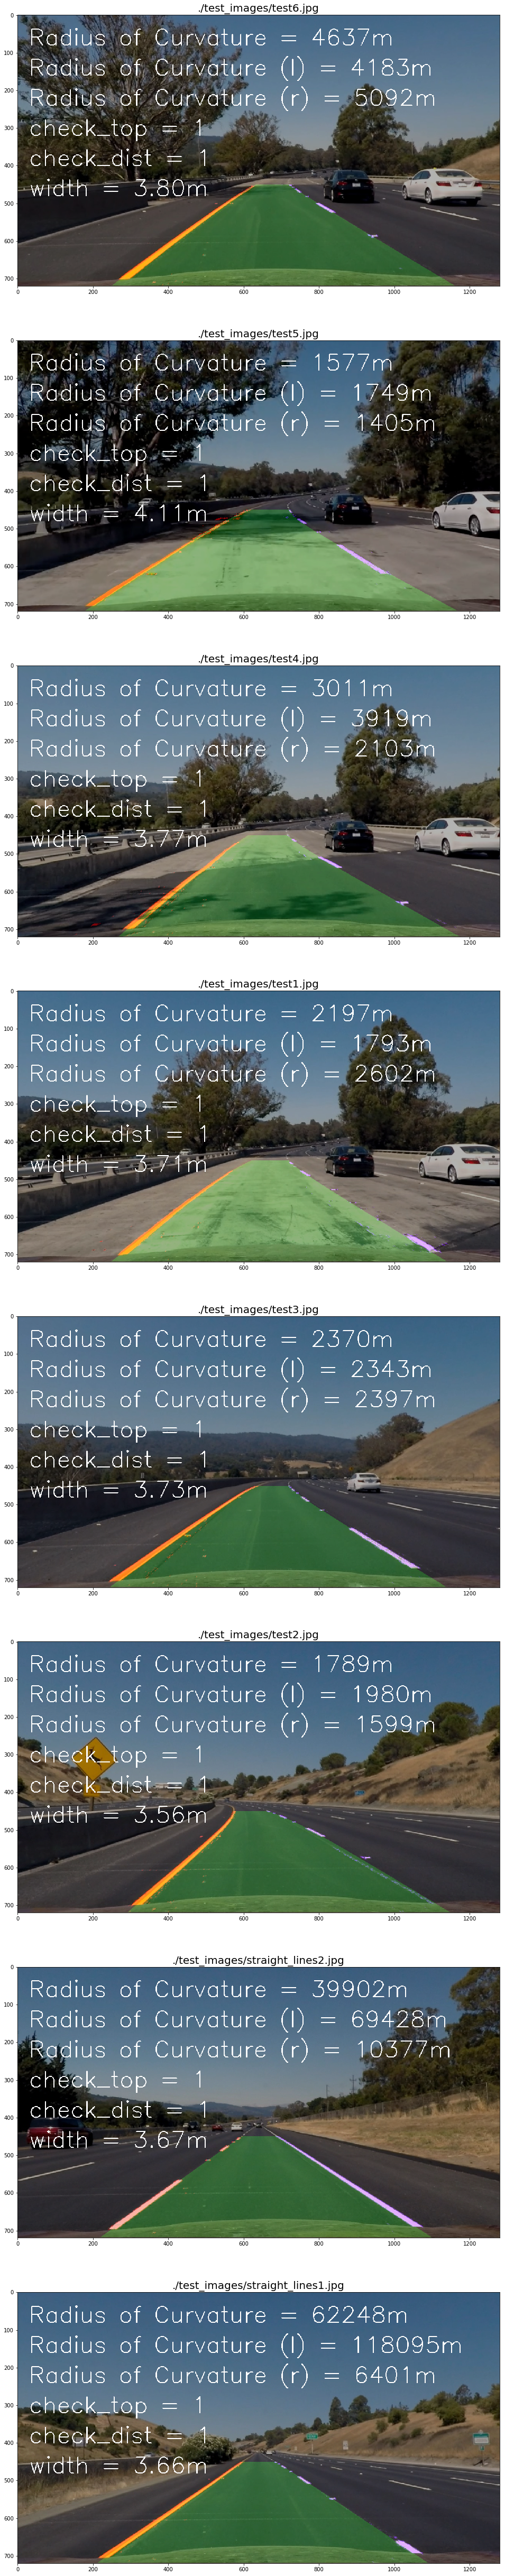

In [451]:
debug_one = False
#debug_image = './test_images/straight_lines1.jpg'
debug_image = './test_images/test6.jpg'
print_steps = debug_one
print_result = not print_steps

test_images = glob.glob('./test_images/*.jpg')
results = []
for fname in test_images:
    if debug_one and fname != debug_image:
        continue
    print('Processing ', fname)
    img = mpimg.imread(fname)
    result, steps = pipeline(img)
    results.append((fname, result))
    if print_steps:
        print_image_grid(steps, 2)
    
if print_result:
    print_image_grid(results, 1)

# Applying the pipeline to the project video

In [442]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_det = None
right_det = None
def process_image(image):
    global left_det
    global right_det
    if left_det is None or right_det is None:
        print('Initializing line detectors')
        history_depth = 5       
        left_det = LineDetector(history_depth)
        right_det = LineDetector(history_depth)
        
    result, _ = pipeline(image, left_det, right_det)
    return result

In [455]:
left_det = None
right_det = None

#filename = 'harder_challenge_video.mp4'
filename = 'challenge_video.mp4'
#filename = 'project_video.mp4'

white_output = 'output_videos/%s' % filename
clip1 = VideoFileClip(filename).subclip(0,5) # the first five seconds for debugging
#clip1 = VideoFileClip(filename).subclip(28,35)
#clip1 = VideoFileClip(filename)

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Initializing line detectors
Topology check failed, lfit= [-9.71593846e-04  5.03611252e-01  5.02434229e+02] rfit= [-1.48693242e-04  1.61554742e-02  9.41447548e+02]
Sanity check failed
[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4




  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:00<00:19,  7.63it/s]

Topology check failed, lfit= [-9.71593846e-04  5.03611252e-01  5.02434229e+02] rfit= [-1.48693242e-04  1.61554742e-02  9.41447548e+02]
Sanity check failed




  1%|▏         | 2/150 [00:00<00:19,  7.44it/s]

Topology check failed, lfit= [-6.57245750e-04  2.27662581e-01  5.59217697e+02] rfit= [ 3.96461695e-08 -1.19290357e-01  9.69088711e+02]
Sanity check failed




  2%|▏         | 3/150 [00:00<00:19,  7.59it/s]

Topology check failed, lfit= [-7.57447695e-04  3.29362658e-01  5.35796893e+02] rfit= [ 6.45572710e-05 -1.75078354e-01  9.79130718e+02]
Sanity check failed




  3%|▎         | 4/150 [00:00<00:19,  7.68it/s]

Topology check failed, lfit= [-8.28280960e-04  4.39096949e-01  4.94843057e+02] rfit= [-5.52844809e-05 -7.48203018e-02  9.63481678e+02]
Sanity check failed




  3%|▎         | 5/150 [00:00<00:18,  7.75it/s]

Topology check failed, lfit= [-8.80890547e-04  4.64623341e-01  4.99872441e+02] rfit= [-3.72384311e-05 -9.07024380e-02  9.64822772e+02]
Sanity check failed




  4%|▍         | 6/150 [00:00<00:18,  7.73it/s]

Topology check failed, lfit= [-1.04102341e-03  6.91366925e-01  4.22918062e+02] rfit= [-1.69287885e-05 -1.19007946e-01  9.74314236e+02]
Sanity check failed




  5%|▍         | 7/150 [00:00<00:18,  7.79it/s]

Topology check failed, lfit= [-1.11747931e-03  7.90101685e-01  3.95127727e+02] rfit= [ 7.27046364e-05 -2.10460973e-01  9.95207745e+02]
Sanity check failed




  5%|▌         | 8/150 [00:01<00:18,  7.78it/s]

Topology check failed, lfit= [-1.01564219e-03  6.90646933e-01  4.17188932e+02] rfit= [-1.34393813e-05 -1.11292038e-01  9.68967152e+02]
Sanity check failed




  6%|▌         | 9/150 [00:01<00:18,  7.77it/s]

Topology check failed, lfit= [-9.41005343e-04  5.93510179e-01  4.51379218e+02] rfit= [-3.13987945e-05 -8.44325035e-02  9.60431721e+02]
Sanity check failed




  7%|▋         | 10/150 [00:01<00:17,  7.81it/s]

Topology check failed, lfit= [-1.13112734e-03  7.74043609e-01  4.11810284e+02] rfit= [-8.35379649e-05 -3.59515215e-02  9.51785466e+02]
Sanity check failed




  7%|▋         | 11/150 [00:01<00:17,  7.72it/s]

  8%|▊         | 12/150 [00:01<00:18,  7.66it/s]

  9%|▊         | 13/150 [00:01<00:17,  7.62it/s]

Distance check failed, diff_m= 0.8068178432230417
Topology check failed, lfit= [ 1.95548103e-03 -2.60446923e+00  1.07580282e+03] rfit= [ 8.56442764e-06 -1.62746553e-01  9.96976444e+02]
Sanity check failed
Distance check failed, diff_m= 1.3481291027737299
Topology check failed, lfit= [ 1.27554575e-03 -2.05247072e+00  9.65482268e+02] rfit= [ 3.19274744e-04 -4.57261157e-01  1.06305984e+03]
Sanity check failed




  9%|▉         | 14/150 [00:01<00:18,  7.55it/s]

 10%|█         | 15/150 [00:01<00:17,  7.52it/s]

Distance check failed, diff_m= 1.3682915628267598
Topology check failed, lfit= [ 1.11108320e-03 -1.89485496e+00  9.26662780e+02] rfit= [ 1.43735821e-04 -2.99939204e-01  1.03319101e+03]
Sanity check failed
Distance check failed, diff_m= 1.2948347663845472
Topology check failed, lfit= [ 1.14188952e-03 -1.91711490e+00  9.29867191e+02] rfit= [-6.56145755e-05 -9.96357333e-02  9.89727753e+02]
Sanity check failed




 11%|█         | 16/150 [00:02<00:17,  7.46it/s]

 11%|█▏        | 17/150 [00:02<00:17,  7.42it/s]

Distance check failed, diff_m= 1.1463271900119814
Topology check failed, lfit= [ 1.38175610e-03 -2.11469155e+00  9.69062879e+02] rfit= [-7.76155324e-05 -9.65801145e-02  9.92960884e+02]
Sanity check failed
Distance check failed, diff_m= 1.0479856761472384
Topology check failed, lfit= [ 1.49166016e-03 -2.17873292e+00  9.74107517e+02] rfit= [-7.88412319e-05 -9.90323071e-02  9.96652648e+02]
Sanity check failed




 12%|█▏        | 18/150 [00:02<00:17,  7.38it/s]

 13%|█▎        | 19/150 [00:02<00:17,  7.36it/s]

Distance check failed, diff_m= 1.152234612403927
Topology check failed, lfit= [ 1.49387798e-03 -2.22589394e+00  1.00103610e+03] rfit= [ 1.05884328e-04 -2.52487027e-01  1.02099715e+03]
Sanity check failed
Distance check failed, diff_m= 1.1930371355273737
Topology check failed, lfit= [ 1.73315537e-03 -2.41843774e+00  1.03202217e+03] rfit= [ 6.54107731e-04 -7.86422882e-01  1.14369313e+03]
Sanity check failed




 13%|█▎        | 20/150 [00:02<00:17,  7.33it/s]

 14%|█▍        | 21/150 [00:02<00:17,  7.32it/s]

Distance check failed, diff_m= 0.5475451877887244
Topology check failed, lfit= [-6.79611390e-04  4.39067837e-01  4.54782608e+02] rfit= [-3.24454836e-05 -1.37269435e-01  1.00286279e+03]
Sanity check failed
Topology check failed, lfit= [-6.30516732e-04  3.61256550e-01  4.83047740e+02] rfit= [ 8.85101918e-04 -9.93657983e-01  1.18758203e+03]
Sanity check failed




 15%|█▍        | 22/150 [00:03<00:17,  7.30it/s]

 15%|█▌        | 23/150 [00:03<00:17,  7.28it/s]

Topology check failed, lfit= [-7.59361816e-04  4.61106792e-01  4.72781712e+02] rfit= [ 1.63599961e-04 -3.26050245e-01  1.04563890e+03]
Sanity check failed
Topology check failed, lfit= [-3.56198978e-04 -4.12482250e-02  6.25901162e+02] rfit= [ 7.64820023e-04 -8.72413679e-01  1.16067659e+03]
Sanity check failed




 16%|█▌        | 24/150 [00:03<00:17,  7.25it/s]

 17%|█▋        | 25/150 [00:03<00:17,  7.22it/s]

Topology check failed, lfit= [-2.22952036e-04 -2.93305581e-02  5.74641371e+02] rfit= [ 5.25244389e-04 -6.63460168e-01  1.11958009e+03]
Sanity check failed
Distance check failed, diff_m= 0.6711811115201175
Topology check failed, lfit= [ 1.52773946e-04 -4.18099075e-01  6.69185614e+02] rfit= [ 1.22687958e-04 -2.81204022e-01  1.03644759e+03]
Sanity check failed




 17%|█▋        | 26/150 [00:03<00:17,  7.22it/s]

 18%|█▊        | 27/150 [00:03<00:17,  7.22it/s]

Distance check failed, diff_m= 0.5527136109054269
Topology check failed, lfit= [ 1.49315065e-04 -4.89448075e-01  7.17239454e+02] rfit= [ 4.14898730e-04 -5.42092393e-01  1.08530466e+03]
Sanity check failed
Distance check failed, diff_m= 0.6563546215375508
Topology check failed, lfit= [ 5.42931421e-04 -8.34016572e-01  7.78691014e+02] rfit= [ 4.18005729e-04 -5.36893649e-01  1.08195776e+03]
Sanity check failed




 19%|█▊        | 28/150 [00:03<00:16,  7.21it/s]

 19%|█▉        | 29/150 [00:04<00:16,  7.21it/s]

Distance check failed, diff_m= 0.615420276842842
Distance check failed, diff_m= 0.5377562721207391
Distance check failed, diff_m= 0.6776323788318701
Topology check failed, lfit= [-5.42987926e-05 -2.41047305e-01  6.45897296e+02] rfit= [-4.43450856e-06 -1.49427083e-01  1.00335195e+03]
Sanity check failed
Distance check failed, diff_m= 0.5377562721207391




 20%|██        | 30/150 [00:04<00:16,  7.20it/s]

 21%|██        | 31/150 [00:04<00:16,  7.18it/s]

Distance check failed, diff_m= 0.7367808060441304
Topology check failed, lfit= [-2.25357529e-05 -2.76275118e-01  6.58835400e+02] rfit= [-2.22640061e-04  7.24527040e-02  9.51963970e+02]
Sanity check failed
Distance check failed, diff_m= 0.5377562721207391
Distance check failed, diff_m= 0.7369900178974759
Topology check failed, lfit= [-1.15187515e-04 -1.47523658e-01  6.13078327e+02] rfit= [-2.54345210e-04  8.30233632e-02  9.59671251e+02]
Sanity check failed
Distance check failed, diff_m= 0.5377562721207391




 21%|██▏       | 32/150 [00:04<00:16,  7.17it/s]

 22%|██▏       | 33/150 [00:04<00:16,  7.17it/s]

Distance check failed, diff_m= 0.6168028408683209
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.845083319281254
Topology check failed, lfit= [ 5.33986055e-04 -7.49190187e-01  7.42778110e+02] rfit= [ 1.32811506e-04 -2.75206120e-01  1.03385797e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 23%|██▎       | 34/150 [00:04<00:16,  7.16it/s]

 23%|██▎       | 35/150 [00:04<00:16,  7.16it/s]

Distance check failed, diff_m= 0.6944459626088065
Topology check failed, lfit= [ 3.98407710e-04 -6.58843123e-01  7.35303132e+02] rfit= [ 4.08101078e-04 -5.67618374e-01  1.11136782e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.7961471758017155
Topology check failed, lfit= [ 4.21348873e-04 -6.99624183e-01  7.50252094e+02] rfit= [-1.36093410e-04 -4.61595100e-02  1.00038941e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 24%|██▍       | 36/150 [00:05<00:15,  7.13it/s]

 25%|██▍       | 37/150 [00:05<00:15,  7.12it/s]

Distance check failed, diff_m= 0.7838537729547903
Topology check failed, lfit= [ 3.11375622e-04 -6.40299997e-01  7.55655527e+02] rfit= [-3.37144120e-04  1.59398415e-01  9.49546501e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Topology check failed, lfit= [ 2.86327705e-04 -5.95801270e-01  7.40171951e+02] rfit= [ 1.16790037e-03 -1.25915248e+00  1.25238450e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 25%|██▌       | 38/150 [00:05<00:15,  7.12it/s]

 26%|██▌       | 39/150 [00:05<00:15,  7.11it/s]

Distance check failed, diff_m= 0.7753195713408418
Topology check failed, lfit= [ 2.76301897e-04 -6.20991806e-01  7.59174431e+02] rfit= [-4.12026265e-04  2.33256855e-01  9.35694508e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.8022305687890972
Topology check failed, lfit= [ 5.27711195e-04 -8.62421955e-01  8.13016436e+02] rfit= [-3.87068792e-04  2.06756830e-01  9.48179165e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 27%|██▋       | 40/150 [00:05<00:15,  7.10it/s]

 27%|██▋       | 41/150 [00:05<00:15,  7.10it/s]

Distance check failed, diff_m= 0.5839253857377091
Topology check failed, lfit= [ 2.79633522e-04 -6.39459504e-01  7.70469500e+02] rfit= [ 2.74429380e-04 -4.63054683e-01  1.10935614e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.8193587639210161
Topology check failed, lfit= [ 4.71489121e-04 -8.07952061e-01  7.99030166e+02] rfit= [-7.72025228e-04  5.82143255e-01  8.71002803e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 28%|██▊       | 42/150 [00:05<00:15,  7.10it/s]

 29%|██▊       | 43/150 [00:06<00:15,  7.09it/s]

Distance check failed, diff_m= 0.7329491206117118
Topology check failed, lfit= [ 5.38653128e-04 -8.64704974e-01  8.08196518e+02] rfit= [-3.80467191e-04  2.52001413e-01  9.21687996e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.580647990034713
Topology check failed, lfit= [ 1.76291218e-04 -5.50585412e-01  7.59740843e+02] rfit= [-2.55606546e-04  1.93531774e-01  9.11559731e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 29%|██▉       | 44/150 [00:06<00:14,  7.09it/s]

 30%|███       | 45/150 [00:06<00:14,  7.09it/s]

Distance check failed, diff_m= 0.689599885337275
Topology check failed, lfit= [ 1.81530971e-04 -5.68046106e-01  7.66746522e+02] rfit= [-6.22353886e-04  3.56656568e-01  9.65186416e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.7190199838780995
Topology check failed, lfit= [-1.49550889e-04 -2.43634293e-01  7.14091628e+02] rfit= [-6.72827825e-04  4.14777482e-01  9.54420565e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 31%|███       | 46/150 [00:06<00:14,  7.09it/s]

 31%|███▏      | 47/150 [00:06<00:14,  7.09it/s]

Distance check failed, diff_m= 0.7918778108451577
Topology check failed, lfit= [ 1.87311270e-04 -5.11622345e-01  7.58518636e+02] rfit= [-5.48001006e-04  3.07685847e-01  9.82091056e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.5055768794656939
Topology check failed, lfit= [-4.17909748e-04  1.76766596e-02  6.58791299e+02] rfit= [-6.13966428e-04  4.13470828e-01  9.50301961e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 32%|███▏      | 48/150 [00:06<00:14,  7.09it/s]

 33%|███▎      | 49/150 [00:06<00:14,  7.09it/s]

Topology check failed, lfit= [-3.16108706e-04 -1.24744036e-01  7.09960376e+02] rfit= [-5.72025972e-04  3.65126955e-01  9.67075319e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.8983878559753871
Topology check failed, lfit= [ 2.65829278e-04 -5.41668074e-01  7.67016136e+02] rfit= [-8.42302102e-04  6.71602215e-01  8.84372694e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 33%|███▎      | 50/150 [00:07<00:14,  7.08it/s]

 34%|███▍      | 51/150 [00:07<00:13,  7.08it/s]

Distance check failed, diff_m= 0.8562749548711281
Topology check failed, lfit= [ 5.74377567e-05 -3.24005071e-01  7.15438627e+02] rfit= [-8.91520123e-04  7.36546001e-01  8.66497505e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.9762036727347772
Topology check failed, lfit= [ 5.44541991e-04 -7.97418574e-01  8.27553706e+02] rfit= [-8.08471671e-04  6.76334805e-01  8.72742199e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 35%|███▍      | 52/150 [00:07<00:13,  7.08it/s]

 35%|███▌      | 53/150 [00:07<00:13,  7.08it/s]

Distance check failed, diff_m= 1.0353427866477114
Topology check failed, lfit= [ 6.25761576e-04 -8.78595443e-01  8.50286799e+02] rfit= [-8.66274698e-04  7.23850312e-01  8.66095153e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 0.9920785105763615
Topology check failed, lfit= [ 4.93165584e-04 -7.63229307e-01  8.33869207e+02] rfit= [-8.22157533e-04  6.91812553e-01  8.70631441e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 36%|███▌      | 54/150 [00:07<00:13,  7.08it/s]

 37%|███▋      | 55/150 [00:07<00:13,  7.08it/s]

Distance check failed, diff_m= 2.303617445649992
Topology check failed, lfit= [ 3.96724552e-04 -6.18146281e-01  7.83476896e+02] rfit= [-4.81005212e-04  7.37161646e-02  9.47921425e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 2.42753107330775
Topology check failed, lfit= [ 4.29955048e-04 -6.47874528e-01  7.94738907e+02] rfit= [-7.14613498e-04  2.75883486e-01  9.12128257e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 37%|███▋      | 56/150 [00:07<00:13,  7.08it/s]

 38%|███▊      | 57/150 [00:08<00:13,  7.08it/s]

Distance check failed, diff_m= 2.309600063181595
Topology check failed, lfit= [ 4.58346567e-04 -6.81431899e-01  8.07524789e+02] rfit= [-5.64053913e-04  1.77628624e-01  9.25694694e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 2.150274846867122
Topology check failed, lfit= [ 2.63413231e-04 -5.35672798e-01  7.95340107e+02] rfit= [-4.55550186e-04  1.49168175e-01  9.05329792e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 39%|███▊      | 58/150 [00:08<00:12,  7.08it/s]

 39%|███▉      | 59/150 [00:08<00:12,  7.08it/s]

Distance check failed, diff_m= 1.9516707152555834
Topology check failed, lfit= [ 2.07202363e-04 -5.17294372e-01  8.10641605e+02] rfit= [-2.60716750e-04  9.26217615e-02  8.73958043e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 2.025052943021307
Topology check failed, lfit= [ 1.94867652e-04 -4.97266609e-01  8.03847347e+02] rfit= [-3.86684774e-04  1.24529980e-01  9.06609196e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 40%|████      | 60/150 [00:08<00:12,  7.08it/s]

 41%|████      | 61/150 [00:08<00:12,  7.08it/s]

Distance check failed, diff_m= 1.7891040242532545
Topology check failed, lfit= [-1.15551263e-04 -2.70812127e-01  7.83051642e+02] rfit= [-2.76525073e-04  2.24133570e-02  9.39430221e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.3973096470428998
Topology check failed, lfit= [-2.22181345e-04 -1.87402958e-01  7.78007073e+02] rfit= [ 1.37415674e-03 -1.61275431e+00  1.31901019e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 41%|████▏     | 62/150 [00:08<00:12,  7.07it/s]

 42%|████▏     | 63/150 [00:08<00:12,  7.07it/s]

Distance check failed, diff_m= 1.435639193374444
Topology check failed, lfit= [-6.16591668e-05 -3.15466019e-01  7.99345896e+02] rfit= [ 1.37715876e-03 -1.60194230e+00  1.31631978e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.3162089010888993
Topology check failed, lfit= [-2.83070558e-04 -1.30908350e-01  7.71476935e+02] rfit= [ 1.48267377e-03 -1.69704831e+00  1.33808317e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 43%|████▎     | 64/150 [00:09<00:12,  7.07it/s]

 43%|████▎     | 65/150 [00:09<00:12,  7.08it/s]

Distance check failed, diff_m= 1.3829518875346434
Topology check failed, lfit= [-1.60552924e-04 -2.41856070e-01  7.98239643e+02] rfit= [ 1.51713000e-03 -1.73710962e+00  1.34953744e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.391868126582351
Topology check failed, lfit= [-3.87677015e-04 -2.15588955e-02  7.55346638e+02] rfit= [ 1.51081381e-03 -1.74724820e+00  1.35676598e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 44%|████▍     | 66/150 [00:09<00:11,  7.07it/s]

 45%|████▍     | 67/150 [00:09<00:11,  7.07it/s]

Distance check failed, diff_m= 1.3746110028203111
Topology check failed, lfit= [-5.63779689e-04  1.36204985e-01  7.27826166e+02] rfit= [ 1.54676968e-03 -1.80089524e+00  1.37409547e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.361360618326106
Topology check failed, lfit= [-3.55494945e-04 -4.37627265e-02  7.62748847e+02] rfit= [ 1.74202286e-03 -1.96670368e+00  1.40754869e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 45%|████▌     | 68/150 [00:09<00:11,  7.07it/s]

 46%|████▌     | 69/150 [00:09<00:11,  7.08it/s]

Distance check failed, diff_m= 1.3722120658419987
Topology check failed, lfit= [-3.09940572e-04 -6.98498176e-02  7.63204094e+02] rfit= [ 1.76638801e-03 -1.98124805e+00  1.40906462e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.468437180648782
Topology check failed, lfit= [-2.52799624e-04 -6.79521689e-02  7.38381285e+02] rfit= [ 1.73638852e-03 -1.98329236e+00  1.41794988e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 47%|████▋     | 70/150 [00:09<00:11,  7.07it/s]

 47%|████▋     | 71/150 [00:10<00:11,  7.07it/s]

Distance check failed, diff_m= 1.627891093423064
Topology check failed, lfit= [-1.85085119e-05 -3.28350228e-01  8.09515550e+02] rfit= [ 1.47125866e-03 -1.75958452e+00  1.37572512e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 2.052204417379437
Topology check failed, lfit= [ 1.02751047e-04 -3.49011471e-01  7.97020694e+02] rfit= [ 1.13639427e-03 -1.49616749e+00  1.33207497e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 48%|████▊     | 72/150 [00:10<00:11,  7.07it/s]

 49%|████▊     | 73/150 [00:10<00:10,  7.08it/s]

Topology check failed, lfit= [ 6.50655426e-04 -1.45121888e+00  9.96694153e+02] rfit= [ 1.09158937e-03 -1.46855132e+00  1.33365054e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Topology check failed, lfit= [ 6.43582390e-04 -1.43733910e+00  9.93272619e+02] rfit= [ 1.03122295e-03 -1.41439537e+00  1.32397013e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 49%|████▉     | 74/150 [00:10<00:10,  7.07it/s]

 50%|█████     | 75/150 [00:10<00:10,  7.07it/s]

Topology check failed, lfit= [ 5.83878691e-04 -1.35772460e+00  9.65954407e+02] rfit= [ 9.61831653e-04 -1.31765699e+00  1.29387843e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Topology check failed, lfit= [ 6.43560421e-04 -1.40158808e+00  9.73681961e+02] rfit= [ 9.27888791e-04 -1.26663663e+00  1.27659759e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 51%|█████     | 76/150 [00:10<00:10,  7.07it/s]

 51%|█████▏    | 77/150 [00:10<00:10,  7.07it/s]

Distance check failed, diff_m= 1.8549927423392043
Topology check failed, lfit= [-5.51579829e-04  1.61351640e-01  7.37768221e+02] rfit= [ 9.32467635e-04 -1.31467758e+00  1.30543689e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Topology check failed, lfit= [ 6.38572144e-04 -1.39534207e+00  9.73041196e+02] rfit= [ 6.36844314e-04 -9.96707780e-01  1.22377199e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 52%|█████▏    | 78/150 [00:11<00:10,  7.07it/s]

 53%|█████▎    | 79/150 [00:11<00:10,  7.07it/s]

Distance check failed, diff_m= 1.623025588871916
Topology check failed, lfit= [-8.98446200e-04  3.19118046e-01  7.63649113e+02] rfit= [ 6.97161116e-04 -1.07943824e+00  1.25218625e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.8760367714964787
Topology check failed, lfit= [-4.92579266e-04  1.05318605e-01  7.56185698e+02] rfit= [ 9.26100567e-04 -1.30727318e+00  1.30893783e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 53%|█████▎    | 80/150 [00:11<00:09,  7.07it/s]

 54%|█████▍    | 81/150 [00:11<00:09,  7.07it/s]

Topology check failed, lfit= [ 6.81192940e-04 -1.42877814e+00  9.86118544e+02] rfit= [ 1.05381219e-03 -1.37965483e+00  1.31522114e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.683188373301174
Topology check failed, lfit= [-8.53891892e-04  4.29108457e-01  6.96579946e+02] rfit= [ 7.87524451e-04 -1.10018849e+00  1.24655984e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 55%|█████▍    | 82/150 [00:11<00:09,  7.07it/s]

 55%|█████▌    | 83/150 [00:11<00:09,  7.07it/s]

Distance check failed, diff_m= 2.06615520477012
Topology check failed, lfit= [-9.83397804e-04  4.25500204e-01  7.43741351e+02] rfit= [-1.09428764e-03  7.11107259e-01  8.38458382e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.6467487338573343
Topology check failed, lfit= [-1.31538702e-03  6.56347043e-01  7.14938138e+02] rfit= [-5.98422555e-04  2.62521947e-01  9.32030854e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 56%|█████▌    | 84/150 [00:11<00:09,  7.07it/s]

 57%|█████▋    | 85/150 [00:12<00:09,  7.07it/s]

Distance check failed, diff_m= 1.571558274974185
Topology check failed, lfit= [-9.80775875e-04  4.31492167e-01  7.39150630e+02] rfit= [ 6.80218389e-04 -1.03224155e+00  1.24836946e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.657024773206714
Topology check failed, lfit= [-8.22055846e-04  2.33665403e-01  8.02052250e+02] rfit= [ 2.21059914e-04 -5.62627823e-01  1.13831767e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 57%|█████▋    | 86/150 [00:12<00:09,  7.07it/s]

 58%|█████▊    | 87/150 [00:12<00:08,  7.07it/s]

Distance check failed, diff_m= 1.7438152310874513
Topology check failed, lfit= [-8.12468782e-04  2.26078278e-01  8.03092834e+02] rfit= [-3.58793482e-04  5.62222894e-02  9.80988092e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.5676920311082823
Topology check failed, lfit= [-1.43172569e-03  9.70364841e-01  5.89835940e+02] rfit= [ 9.13927354e-04 -1.25731050e+00  1.29474034e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 59%|█████▊    | 88/150 [00:12<00:08,  7.07it/s]

 59%|█████▉    | 89/150 [00:12<00:08,  7.07it/s]

Distance check failed, diff_m= 1.860579341850503
Topology check failed, lfit= [-6.89281814e-04  1.10140564e-01  8.33147302e+02] rfit= [-1.07709484e-03  9.42973998e-01  7.07976896e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.6880876301169225
Topology check failed, lfit= [-1.52937722e-03  9.69603256e-01  6.21424782e+02] rfit= [-1.26274138e-03  1.15482891e+00  6.48906349e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 60%|██████    | 90/150 [00:12<00:08,  7.07it/s]

 61%|██████    | 91/150 [00:12<00:08,  7.07it/s]

Distance check failed, diff_m= 1.805832094583998
Topology check failed, lfit= [-1.05005177e-03  4.66908352e-01  7.47935764e+02] rfit= [-1.47586330e-03  1.37964830e+00  5.93069203e+02]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 2.023239612853561
Topology check failed, lfit= [ 1.77991076e-04 -7.23744293e-01  1.02296565e+03] rfit= [ 3.21048184e-04 -6.59935254e-01  1.15211050e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 61%|██████▏   | 92/150 [00:13<00:08,  7.07it/s]

 62%|██████▏   | 93/150 [00:13<00:08,  7.07it/s]

Distance check failed, diff_m= 2.057779761248412
Topology check failed, lfit= [-5.38073162e-05 -4.81147889e-01  9.63486907e+02] rfit= [ 1.18488231e-04 -4.66150046e-01  1.10748427e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Distance check failed, diff_m= 1.980360989922214
Topology check failed, lfit= [-1.01899581e-04 -4.45548408e-01  9.56128215e+02] rfit= [ 1.32680905e-04 -4.69770738e-01  1.10758378e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 63%|██████▎   | 94/150 [00:13<00:07,  7.07it/s]

 63%|██████▎   | 95/150 [00:13<00:07,  7.07it/s]

Topology check failed, lfit= [ 9.96603813e-04 -1.62693863e+00  1.00039840e+03] rfit= [ 1.02698450e-04 -4.46496499e-01  1.10533282e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322
Topology check failed, lfit= [ 1.06586386e-03 -1.71919222e+00  1.03309391e+03] rfit= [ 3.16639454e-05 -3.34676718e-01  1.06363551e+03]
Sanity check failed
Distance check failed, diff_m= 0.5641051283699322




 64%|██████▍   | 96/150 [00:13<00:07,  7.07it/s]

 65%|██████▍   | 97/150 [00:13<00:07,  7.06it/s]

Distance check failed, diff_m= 2.0214076449337632
Distance check failed, diff_m= 0.9284307575108902
Distance check failed, diff_m= 1.99343038989072
Topology check failed, lfit= [-1.40429178e-03  1.02723818e+00  5.55317869e+02] rfit= [-2.29841019e-04 -8.94925472e-02  1.00420798e+03]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 65%|██████▌   | 98/150 [00:13<00:07,  7.06it/s]

 66%|██████▌   | 99/150 [00:14<00:07,  7.06it/s]

Distance check failed, diff_m= 2.360335300329563
Topology check failed, lfit= [-1.15945148e-04 -2.69897915e-01  8.67508980e+02] rfit= [-4.29367473e-04  1.10932602e-01  9.54928488e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902
Distance check failed, diff_m= 2.402927075139406
Topology check failed, lfit= [-1.18833046e-04 -2.59066433e-01  8.63251869e+02] rfit= [-6.09242500e-04  3.00592440e-01  9.07333878e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 67%|██████▋   | 100/150 [00:14<00:07,  7.06it/s]

 67%|██████▋   | 101/150 [00:14<00:06,  7.06it/s]

Distance check failed, diff_m= 0.7303537731145877
Topology check failed, lfit= [ 1.61644446e-03 -2.38005507e+00  1.24332215e+03] rfit= [-6.78131107e-04  3.57250814e-01  9.03403776e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902
Distance check failed, diff_m= 0.5137323772245428
Topology check failed, lfit= [ 1.71050369e-03 -2.42679486e+00  1.23407863e+03] rfit= [ 2.98225923e-05 -2.70790583e-01  1.02665501e+03]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 68%|██████▊   | 102/150 [00:14<00:06,  7.06it/s]

 69%|██████▊   | 103/150 [00:14<00:06,  7.06it/s]

Distance check failed, diff_m= 0.5684763312901748
Topology check failed, lfit= [ 1.78997678e-03 -2.47069363e+00  1.22868472e+03] rfit= [-1.14646913e-04 -1.56837264e-01  1.01556183e+03]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902
Distance check failed, diff_m= 0.5821327390094949
Topology check failed, lfit= [ 1.85874938e-03 -2.52382106e+00  1.23438488e+03] rfit= [-1.29920084e-04 -1.41445139e-01  1.01346721e+03]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 69%|██████▉   | 104/150 [00:14<00:06,  7.06it/s]

 70%|███████   | 105/150 [00:14<00:06,  7.06it/s]

Distance check failed, diff_m= 0.5336839178753399
Topology check failed, lfit= [ 1.67519953e-03 -2.31616380e+00  1.16665140e+03] rfit= [-2.23408578e-04 -7.19274007e-02  1.00570825e+03]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902
Distance check failed, diff_m= 0.5825610076280281
Topology check failed, lfit= [ 1.73941337e-03 -2.39132916e+00  1.18413085e+03] rfit= [-3.16031247e-04  3.21044020e-03  9.89007913e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 71%|███████   | 106/150 [00:15<00:06,  7.05it/s]

 71%|███████▏  | 107/150 [00:15<00:06,  7.05it/s]

Distance check failed, diff_m= 0.5556450054162564
Topology check failed, lfit= [ 1.55172481e-03 -2.24654914e+00  1.15744941e+03] rfit= [-4.20085170e-04  7.52563318e-02  9.75339882e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902
Topology check failed, lfit= [ 1.67184678e-03 -2.38696663e+00  1.19740741e+03] rfit= [-3.81578994e-04  7.50723717e-02  9.65188731e+02]
Sanity check failed
Distance check failed, diff_m= 0.9284307575108902




 72%|███████▏  | 108/150 [00:15<00:05,  7.05it/s]

 73%|███████▎  | 109/150 [00:15<00:05,  7.05it/s]

Distance check failed, diff_m= 2.1386314815016005
Distance check failed, diff_m= 1.1704709023090314
Distance check failed, diff_m= 2.114642925645582
Distance check failed, diff_m= 1.5013810339584215




 73%|███████▎  | 110/150 [00:15<00:05,  7.05it/s]

 74%|███████▍  | 111/150 [00:15<00:05,  7.05it/s]

Distance check failed, diff_m= 2.385405803808539
Distance check failed, diff_m= 1.8553781393515605
Distance check failed, diff_m= 2.4829914545143392
Distance check failed, diff_m= 2.228615862080765




 75%|███████▍  | 112/150 [00:15<00:05,  7.05it/s]

 75%|███████▌  | 113/150 [00:16<00:05,  7.05it/s]

Topology check failed, lfit= [ 2.07534655e-03 -2.99893455e+00  1.41804493e+03] rfit= [-4.84542025e-04  3.39500796e-01  8.47055993e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 0.6932491569216912
Topology check failed, lfit= [ 4.12779593e-03 -5.24119862e+00  2.03375352e+03] rfit= [-4.27358930e-04  3.20091577e-01  8.37966303e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 76%|███████▌  | 114/150 [00:16<00:05,  7.05it/s]



Topology check failed, lfit= [ 2.48978491e-03 -3.53890322e+00  1.59135385e+03] rfit= [-3.51249000e-04  2.68186144e-01  8.46866573e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 0.613032845304239
Topology check failed, lfit= [ 4.12577706e-03 -5.21359193e+00  2.01933093e+03] rfit= [-3.04031050e-04  2.40467425e-01  8.47694222e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765


 77%|███████▋  | 115/150 [00:16<00:04,  7.04it/s]

 77%|███████▋  | 116/150 [00:16<00:04,  7.03it/s]

 78%|███████▊  | 117/150 [00:16<00:04,  7.03it/s]

Distance check failed, diff_m= 0.6105161848089131
Topology check failed, lfit= [ 4.12902229e-03 -5.18037258e+00  1.99730341e+03] rfit= [-3.51484088e-04  2.95922560e-01  8.36313008e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 2.0922569490562237
Topology check failed, lfit= [ 3.66751263e-04 -7.28275498e-01  9.59137935e+02] rfit= [-3.71109637e-04  3.11371578e-01  8.32087963e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 79%|███████▊  | 118/150 [00:16<00:04,  7.03it/s]

 79%|███████▉  | 119/150 [00:16<00:04,  7.03it/s]

Distance check failed, diff_m= 2.066727878821115
Topology check failed, lfit= [ 3.84540304e-04 -7.42793933e-01  9.61434491e+02] rfit= [-3.72816591e-04  3.59284409e-01  8.03335593e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Topology check failed, lfit= [ 5.32597045e-03 -6.94317346e+00  2.63241836e+03] rfit= [ 6.62608725e-04 -8.33416830e-01  1.13671391e+03]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 80%|████████  | 120/150 [00:17<00:04,  7.03it/s]

 81%|████████  | 121/150 [00:17<00:04,  7.02it/s]

Distance check failed, diff_m= 2.776460473864282
Topology check failed, lfit= [-1.00292220e-03  4.72702074e-01  7.45056335e+02] rfit= [-2.02318758e-03  1.50516873e+00  6.67868820e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 3.0658764615869587
Topology check failed, lfit= [ 1.25348571e-03 -9.61520560e-01  7.54215843e+02] rfit= [-9.15861061e-04  7.24755063e-01  7.58948370e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 81%|████████▏ | 122/150 [00:17<00:03,  7.02it/s]

Distance check failed, diff_m= 2.0978218764346437
Topology check failed, lfit= [-6.17174581e-04  1.35527773e-01  8.08003141e+02] rfit= [-8.05982166e-04  6.83554500e-01  7.49463363e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 82%|████████▏ | 123/150 [00:17<00:03,  6.97it/s]

Distance check failed, diff_m= 1.9612214331986526
Topology check failed, lfit= [-9.24059858e-04  4.46713667e-01  7.32326905e+02] rfit= [-7.94997353e-04  7.29062037e-01  7.20597160e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 83%|████████▎ | 124/150 [00:17<00:03,  6.96it/s]

Distance check failed, diff_m= 1.956093087571906
Topology check failed, lfit= [-9.3143680e-04  4.5547316e-01  7.3146269e+02] rfit= [-8.20931588e-04  7.53152576e-01  7.19077015e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 2.0421410197667624
Topology check failed, lfit= [-8.51476597e-04  3.92063601e-01  7.39099571e+02] rfit= [-8.36351872e-04  6.67958443e-01  7.79053123e+02]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765




 83%|████████▎ | 125/150 [00:18<00:03,  6.94it/s]

 84%|████████▍ | 126/150 [00:18<00:03,  6.92it/s]

Distance check failed, diff_m= 1.7278854376120378
Topology check failed, lfit= [-9.16860349e-04  4.55432526e-01  7.26305864e+02] rfit= [ 6.35986783e-04 -8.15489909e-01  1.12952623e+03]
Sanity check failed
Distance check failed, diff_m= 2.228615862080765
Distance check failed, diff_m= 1.978891705270191
Distance check failed, diff_m= 2.2201126741480492




 85%|████████▍ | 127/150 [00:18<00:03,  6.91it/s]

 85%|████████▌ | 128/150 [00:18<00:03,  6.90it/s]

Distance check failed, diff_m= 1.8970952053723598
Distance check failed, diff_m= 2.171805418922202
Distance check failed, diff_m= 2.0425030687034007
Topology check failed, lfit= [ 3.92415153e-04 -7.54307082e-01  9.65158494e+02] rfit= [ 5.88650505e-04 -7.68166585e-01  1.11979361e+03]
Sanity check failed
Distance check failed, diff_m= 2.171805418922202




 86%|████████▌ | 129/150 [00:18<00:03,  6.89it/s]

 87%|████████▋ | 130/150 [00:18<00:02,  6.88it/s]

Distance check failed, diff_m= 2.0756612691110496
Topology check failed, lfit= [ 3.66167647e-04 -7.35112592e-01  9.62973948e+02] rfit= [ 2.91011928e-04 -4.87972211e-01  1.06544936e+03]
Sanity check failed
Distance check failed, diff_m= 2.171805418922202
Distance check failed, diff_m= 2.021996787103172
Topology check failed, lfit= [ 9.13023980e-05 -4.98108787e-01  9.18560852e+02] rfit= [-1.72726465e-04 -2.48528035e-02  9.64122016e+02]
Sanity check failed




 87%|████████▋ | 131/150 [00:19<00:02,  6.86it/s]

 88%|████████▊ | 132/150 [00:19<00:02,  6.85it/s]

Distance check failed, diff_m= 2.171805418922202
Distance check failed, diff_m= 3.4126452257899533
Distance check failed, diff_m= 2.431405878951078




 89%|████████▊ | 133/150 [00:19<00:02,  6.80it/s]

Distance check failed, diff_m= 0.5527663471890065
Topology check failed, lfit= [ 6.16904950e-04 -9.83011183e-01  7.72635689e+02] rfit= [ 2.98995200e-04 -5.21298882e-01  1.07283928e+03]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 89%|████████▉ | 134/150 [00:19<00:02,  6.77it/s]

Topology check failed, lfit= [ 4.32789931e-04 -9.05920908e-01  7.61163766e+02] rfit= [ 9.56275930e-05 -3.58601965e-01  1.04081046e+03]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Distance check failed, diff_m= 1.2352883115716446
Topology check failed, lfit= [ 3.17577537e-04 -8.72235681e-01  7.65948458e+02] rfit= [ 6.85515357e-04 -9.49146380e-01  9.96961257e+02]
Sanity check failed




 90%|█████████ | 135/150 [00:19<00:02,  6.76it/s]

 91%|█████████ | 136/150 [00:20<00:02,  6.75it/s]

Distance check failed, diff_m= 2.431405878951078
Topology check failed, lfit= [ 3.34954750e-04 -8.72863898e-01  7.63581602e+02] rfit= [-4.74768568e-04  1.67523471e-01  9.25684688e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 91%|█████████▏| 137/150 [00:20<00:01,  6.74it/s]

Distance check failed, diff_m= 1.6218401998797503
Topology check failed, lfit= [ 4.66025645e-04 -9.17114853e-01  7.60793937e+02] rfit= [ 5.78838883e-04 -8.80299290e-01  9.84719995e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Topology check failed, lfit= [ 4.49672157e-04 -9.12478905e-01  7.62941621e+02] rfit= [ 3.66039580e-04 -2.18284627e-01  9.28192378e+02]
Sanity check failed




 92%|█████████▏| 138/150 [00:20<00:01,  6.73it/s]

 93%|█████████▎| 139/150 [00:20<00:01,  6.72it/s]

Distance check failed, diff_m= 2.431405878951078
Distance check failed, diff_m= 1.6547417829646132
Topology check failed, lfit= [ 4.22112889e-04 -9.01466924e-01  7.62486644e+02] rfit= [ 5.00814141e-04 -8.43000291e-01  9.83616809e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 93%|█████████▎| 140/150 [00:20<00:01,  6.71it/s]

 94%|█████████▍| 141/150 [00:21<00:01,  6.71it/s]

Distance check failed, diff_m= 0.5098781502644442
Topology check failed, lfit= [ 9.26904812e-05 -7.72236085e-01  7.59608641e+02] rfit= [-6.80692557e-04  1.58164542e-01  9.64849259e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Topology check failed, lfit= [ 1.61651461e-04 -8.01676009e-01  7.67500206e+02] rfit= [-6.30137675e-04  1.86534514e-01  9.46143581e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 95%|█████████▍| 142/150 [00:21<00:01,  6.69it/s]

Distance check failed, diff_m= 0.8800941533870473
Topology check failed, lfit= [ 3.34543212e-04 -8.99140222e-01  7.87230989e+02] rfit= [-1.07225598e-03  6.06455159e-01  8.51662210e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Distance check failed, diff_m= 0.9275373641316226
Topology check failed, lfit= [ 5.06935449e-04 -1.00085893e+00  8.10118023e+02] rfit= [-9.09455170e-04  5.46111645e-01  8.42678928e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 95%|█████████▌| 143/150 [00:21<00:01,  6.68it/s]

 96%|█████████▌| 144/150 [00:21<00:00,  6.67it/s]

Distance check failed, diff_m= 1.1046523271516948
Topology check failed, lfit= [ 3.61340145e-04 -9.15255370e-01  7.94366925e+02] rfit= [-1.25598323e-03  7.34578934e-01  8.30701589e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Distance check failed, diff_m= 1.1794069603733217
Topology check failed, lfit= [ 3.78818483e-04 -9.20086830e-01  7.94309460e+02] rfit= [-1.31460941e-03  7.82268005e-01  8.21169747e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 97%|█████████▋| 145/150 [00:21<00:00,  6.67it/s]

 97%|█████████▋| 146/150 [00:21<00:00,  6.65it/s]

 98%|█████████▊| 147/150 [00:22<00:00,  6.65it/s]

Distance check failed, diff_m= 0.969389708171122
Topology check failed, lfit= [ 1.87717512e-04 -7.64661641e-01  7.44087957e+02] rfit= [-1.38351785e-03  8.08530273e-01  8.31819722e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Distance check failed, diff_m= 0.9054525330940993
Topology check failed, lfit= [ 1.87311584e-04 -7.57518898e-01  7.38931747e+02] rfit= [-1.39296824e-03  8.41694792e-01  8.22120658e+02]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




 99%|█████████▊| 148/150 [00:22<00:00,  6.64it/s]

Topology check failed, lfit= [ 1.68417373e-04 -7.52135242e-01  7.40657859e+02] rfit= [ 5.76433451e-04 -7.78580225e-01  1.13286067e+03]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078
Topology check failed, lfit= [ 1.99208204e-04 -7.78899448e-01  7.48177877e+02] rfit= [ 6.00306734e-04 -8.12904410e-01  1.14190513e+03]
Sanity check failed




 99%|█████████▉| 149/150 [00:22<00:00,  6.63it/s]

Distance check failed, diff_m= 2.431405878951078
Topology check failed, lfit= [ 2.20235882e-04 -7.82746336e-01  7.48054105e+02] rfit= [ 5.73816229e-04 -7.74342456e-01  1.13008180e+03]
Sanity check failed
Distance check failed, diff_m= 2.431405878951078




100%|██████████| 150/150 [00:22<00:00,  6.62it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 29.2 s, sys: 5.08 s, total: 34.3 s
Wall time: 23.5 s


In [457]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))